In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

import scipy.cluster.hierarchy as shc

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### Get data and gb day and substance

In [2]:
path = 'data_final_clean_3s_221019.csv'
    
data = pd.read_csv(path)
data = pd.DataFrame(data = data)
print(data.shape)
data.head()

(65191, 51)


,Unnamed: 0,Unnamed: 0.1,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,weight_pre,weight_post,weight_diff,notes,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,Cage_VDM_update,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,VDM_RFID_timediff,VDM_RFID_timediff_bool,day_count,min_count,sec_count,hour_count_running,min_count_running,sec_count_running,substance,value_wt
0,0,0,poly,six_four,22.10.10,na,1,041AC165FE,2137.0,NaN,na,male,4,29.7,NaN,NaN,NaN,2,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 16:17:51,drink_1,0.021,2022-10-10 16:17:51,1.665419e+09,2022-10-10,10,16:17:51,16,17,51,light,VDM_EtOH05,1.0,22.395,041AC165FE,etoh_05,2022-10-10 16:17:46.580035200,2022-10-10 16:18:08.975035200,light,1,0.0,same,1,977,58671,16,977,58611,EtOH05,0.707071
1,1,1,poly,six_four,22.10.10,na,1,041AC165FE,2137.0,NaN,na,male,4,29.7,NaN,NaN,NaN,3,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 16:17:54,drink_1,0.021,2022-10-10 16:17:54,1.665419e+09,2022-10-10,10,16:17:54,16,17,54,light,VDM_EtOH05,1.0,22.395,041AC165FE,etoh_05,2022-10-10 16:17:46.580035200,2022-10-10 16:18:08.975035200,light,1,0.0,same,1,977,58674,16,977,58614,EtOH05,0.707071
2,2,2,poly,six_four,22.10.10,na,1,041AC165FE,2137.0,NaN,na,male,4,29.7,NaN,NaN,NaN,4,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 16:17:57,drink_1,0.021,2022-10-10 16:17:57,1.665419e+09,2022-10-10,10,16:17:57,16,17,57,light,VDM_EtOH05,1.0,22.395,041AC165FE,etoh_05,2022-10-10 16:17:46.580035200,2022-10-10 16:18:08.975035200,light,1,0.0,same,1,977,58677,16,977,58617,EtOH05,0.707071
3,3,3,poly,six_four,22.10.10,na,1,041AC165FE,2137.0,NaN,na,male,4,29.7,NaN,NaN,NaN,5,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 16:17:59,drink_1,0.021,2022-10-10 16:17:59,1.665419e+09,2022-10-10,10,16:17:59,16,17,59,light,VDM_EtOH05,1.0,22.395,041AC165FE,etoh_05,2022-10-10 16:17:46.580035200,2022-10-10 16:18:08.975035200,light,1,0.0,same,1,977,58679,16,977,58619,EtOH05,0.707071
4,4,4,poly,six_four,22.10.10,na,1,041AC165FE,2137.0,NaN,na,male,4,29.7,NaN,NaN,NaN,15,w_e10_f20_w_e5_f5_mf_221010.csv,2,10/10/22 17:28:38,drink_1,0.021,2022-10-10 17:28:38,1.665423e+09,2022-10-10,10,17:28:38,17,28,38,light,VDM_EtOH05,1.0,19.446,041AC165FE,etoh_05,2022-10-10 17:28:30.700963200,2022-10-10 17:28:50.146963200,light,1,0.0,same,1,1048,62918,17,1048,62858,EtOH05,0.707071


In [3]:
data['Housing'] = ['single' if x==1 else 'multiple' for x in data['Cage_N']]

In [4]:
#@title day
df_day = data.sort_values(by=['IdRFID','day_count']).reset_index()
params = ['Startdate', 'Sex', 'Housing', 'IdRFID', 'substance', 'value_wt', 'ld_cycle']
df_day=df_day[params]
flavors=df_day.pivot(columns='substance',values='value_wt')
flavors= flavors.fillna(0)
df_day = df_day[['Startdate', 'Sex', 'Housing', 'IdRFID', 'ld_cycle' ]].join(flavors)
df_day.head()

,Startdate,Sex,Housing,IdRFID,ld_cycle,EtOH05,EtOH10,Fent05,Fent20,water
0,22.05.18,male,multiple,041ABFE4E6,dark,0.0,0.0,0.0,0.0,0.83045
1,22.05.18,male,multiple,041ABFE4E6,dark,0.0,0.0,0.0,0.0,0.83045
2,22.05.18,male,multiple,041ABFE4E6,dark,0.0,0.0,0.0,0.0,0.83045
3,22.05.18,male,multiple,041ABFE4E6,dark,0.0,0.0,0.0,0.0,0.83045
4,22.05.18,male,multiple,041ABFE4E6,dark,0.0,0.0,0.0,0.0,0.83045


In [5]:
block_df = df_day.groupby(['Startdate', 'Sex', 'Housing', 'IdRFID'])['EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water'].sum().reset_index()

block_df.head()

,Startdate,Sex,Housing,IdRFID,EtOH05,EtOH10,Fent05,Fent20,water
0,22.04.20,female,multiple,041AC16447,683.269231,4.615385,59.711538,280.288462,208.365385
1,22.04.20,female,multiple,041AC1667D,331.520737,3.317972,44.792627,603.225806,97.695853
2,22.04.20,female,multiple,041AC16A00,1047.037037,40.000000,42.500000,244.444444,85.185185
3,22.04.20,male,multiple,041AC1620E,94.153846,2.230769,1359.230769,16.000000,160.730769
4,22.04.20,male,multiple,041AC162AC,27.000000,2.250000,27.000000,21.000000,477.750000


In [6]:
block_df.columns.values

array(['Startdate', 'Sex', 'Housing', 'IdRFID', 'EtOH05', 'EtOH10',
       'Fent05', 'Fent20', 'water'], dtype=object)

### Cluster

In [7]:
data_cluster = block_df[['EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water']]

# center and scale the data
scaler = StandardScaler()
#scaler = RobustScaler()

data_cluster_scaled = scaler.fit_transform(data_cluster)

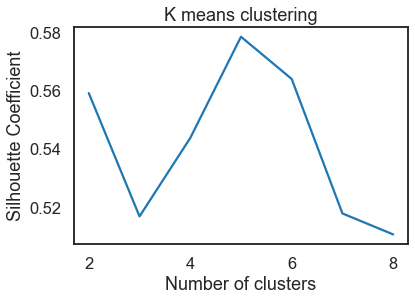

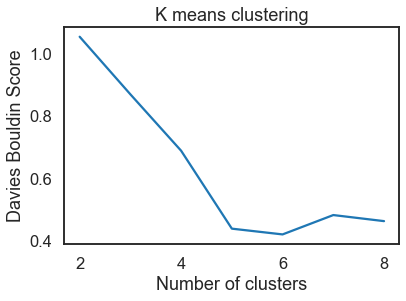

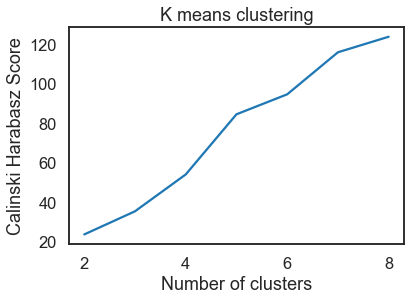

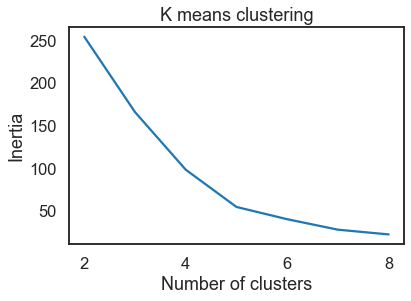

In [8]:
data_kmeans = data_cluster_scaled

#pick cluster number based on silhouette coefficient
k_range = range(2,9)

base_scores = []
sil_scores = []
db_scores = []
ch_scores = []
mse_scores = []

for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=39)
    km_ss.fit(data_kmeans)
    
    sil_scores.append(metrics.silhouette_score(data_kmeans, km_ss.labels_))
    db_scores.append(metrics.davies_bouldin_score(data_kmeans, km_ss.labels_))
    ch_scores.append(metrics.calinski_harabasz_score(data_kmeans, km_ss.labels_))
    mse_scores.append(km_ss.inertia_)
    

# plot the results
plt.plot(k_range, sil_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

# plot the results
plt.plot(k_range, db_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Davies Bouldin Score')
plt.show()

# plot the results
plt.plot(k_range, ch_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski Harabasz Score')
plt.show()
    
# plot the results
plt.plot(k_range, mse_scores)
plt.title('K means clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

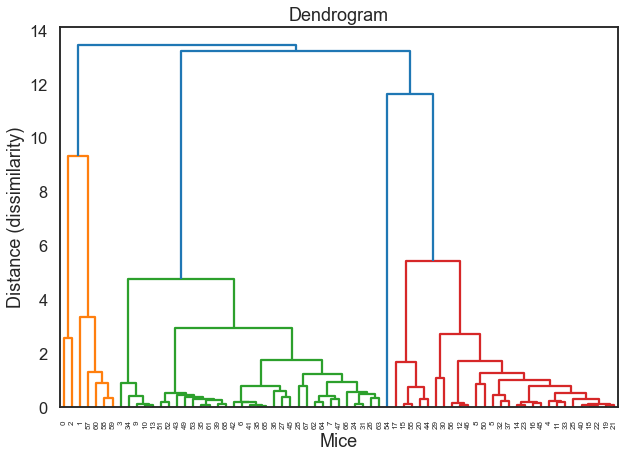

In [9]:
#viz dendrogram to find if three clusters makes sense
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
plt.ylabel("Distance (dissimilarity)")
plt.xlabel("Mice")
dend = shc.dendrogram(shc.linkage(data_cluster_scaled, method='ward'), 
                      distance_sort='ascending', 
                      show_leaf_counts=True, leaf_font_size=8)

<Figure size 720x720 with 0 Axes>

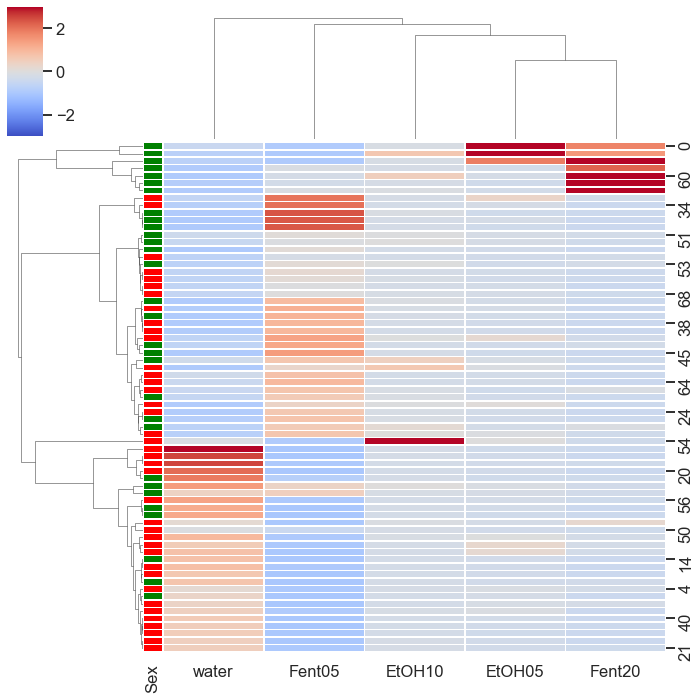

In [10]:
params = ['EtOH05', 'EtOH10', 'Fent05', 'Fent20', 'water']

lut = dict(zip(block_df['Sex'].unique(), "gr"))
row_colors = block_df['Sex'].map(lut)
plt.figure(figsize=(10,10))

g = sns.clustermap(block_df[params], row_colors=row_colors,
                 metric="euclidean", z_score=1, method="ward",
               vmin=-3, vmax=3, center=0, cmap = 'coolwarm', 
               square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [11]:
lut

{'female': 'g', 'male': 'r'}

In [12]:
#choose k=3 clusters and fit data
km_3 = KMeans(n_clusters=3,random_state=99)
km_3.fit(data_cluster_scaled)

block_df['kmeans_cluster'] = ["cluster_" + str(label) for label in km_3.labels_ ]
print(block_df.shape)
block_df.head(1)

(69, 10)


,Startdate,Sex,Housing,IdRFID,EtOH05,EtOH10,Fent05,Fent20,water,kmeans_cluster
0,22.04.20,female,multiple,041AC16447,683.269231,4.615385,59.711538,280.288462,208.365385,cluster_1


In [13]:
block_df['kmeans_cluster'].value_counts()

cluster_0    34
cluster_2    28
cluster_1    7 
Name: kmeans_cluster, dtype: int64

### Viz

#### what can we see in the raw data

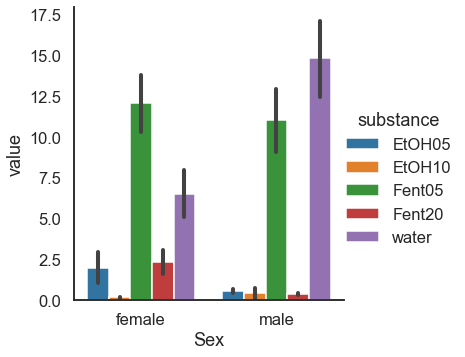

In [14]:
data_gb_sum = data.groupby(['Sex', 'Cage', 'Housing', 'IdRFID', 'substance'])['value',].sum().reset_index()

sns.catplot(x='Sex', y='value', data=data_gb_sum,  kind='bar', 
            ci=68, height=5, aspect=1, hue='substance',
           )

plt.show()

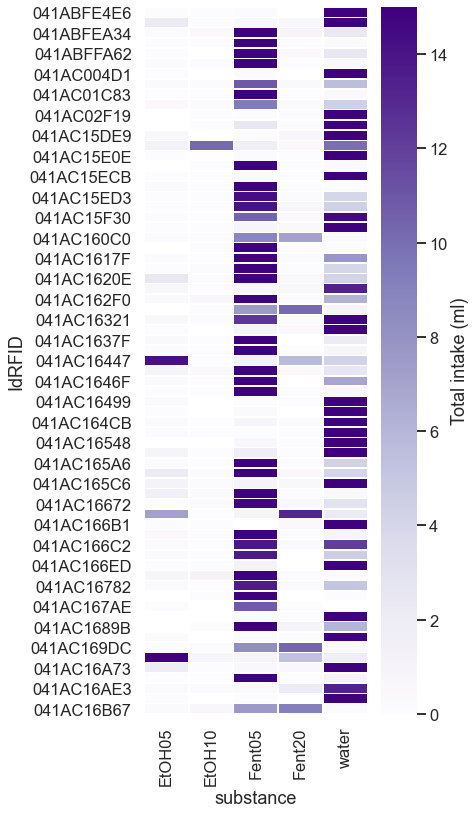

In [15]:
groupby = data_gb_sum.pivot('IdRFID', 'substance', "value")
plt.figure(figsize=(5,13))
ax = sns.heatmap(groupby, cmap="Purples", vmin=0, vmax=15, linewidths=.5, cbar_kws={'label': 'Total intake (ml)'})

plt.show()

#### do we see something more with the clustering

In [16]:
data_gb_sum = data_gb_sum.merge(block_df[['IdRFID', 'kmeans_cluster']], on='IdRFID')
print(data_gb_sum.shape)
data_gb_sum.head()

(313, 7)


,Sex,Cage,Housing,IdRFID,substance,value,kmeans_cluster
0,female,1,multiple,041ABFEA34,EtOH05,0.231,cluster_0
1,female,1,multiple,041ABFEA34,EtOH10,0.378,cluster_0
2,female,1,multiple,041ABFEA34,Fent05,16.065,cluster_0
3,female,1,multiple,041ABFEA34,Fent20,0.924,cluster_0
4,female,1,multiple,041ABFEA34,water,2.331,cluster_0


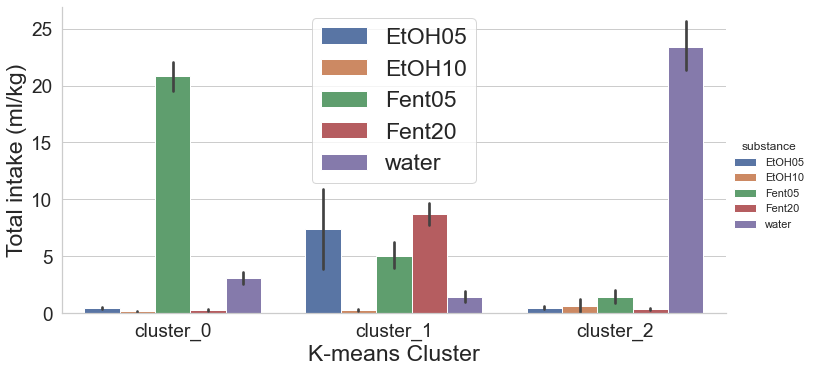

In [20]:
sns.set_theme(style="whitegrid")

plt.rc('xtick', labelsize=19) 
plt.rc('ytick', labelsize=19) 

order = ['cluster_0', 'cluster_1', 'cluster_2']

sns.catplot(x='kmeans_cluster', y='value', kind='bar', ci=68, data=data_gb_sum, 
            height=5, aspect=2, hue='substance', order=order, 
           )

plt.xlabel('K-means Cluster', fontsize=23)
plt.ylabel('Total intake (ml/kg)', fontsize=23)
plt.legend(fontsize=23, loc='upper center')
#plt.title('Male', fontsize=23)
#plt.ylabel('Daily Intake (ml)')
#plt.xticks(rotation=45)

plt.show()

In [ ]:
block_df['kmeans_cluster'].value_counts()

#### combine with behavioral pretesting

In [21]:
path_behav = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/meta/RFID_VDM_behavior.xlsx'

data_behav = pd.read_excel(path_behav)
data_behav = pd.DataFrame(data = data_behav)

data_behav.head()

,Cohort,Behavior_Date,RFID_VDM_Date,Cage,IdRFID,Animal,ARF_cage,Sex,Cage_N,Weight,RFID_VDM_notes,Notes,EZM_distance,EZM_speed,EZM_entries,EZM_time,EZM_distance2,EZM_latency,OFB_distance,OFB_speed,OFB_entries,OFB_time,OFB_distance2,OFB_latency
0,1,22.04.18,22.04.20,1,041AC162AC,1822,549,male,3,28.0,NaN,sim,5.299,0.018,13.0,31.8,0.249,0.0,33.164,0.111,28.0,66.0,9.867,0.0
1,1,22.04.18,22.04.20,1,041AC16AE3,1823,549,male,3,27.8,NaN,NaN,6.942,0.023,24.0,46.2,0.832,0.0,25.964,0.087,17.0,25.6,4.490,17.3
2,1,22.04.18,22.04.20,1,041AC165C6,1824,549,male,3,28.7,NaN,sim,8.898,0.030,15.0,139.0,3.860,0.0,28.521,0.095,11.0,17.2,3.440,51.6
3,1,22.04.18,22.04.20,3,041AC166BB,1825,550,male,3,26.8,NaN,NaN,8.426,0.028,11.0,9.3,0.088,22.5,26.825,0.089,14.0,32.7,3.750,0.3
4,1,22.04.18,22.04.20,3,041AC1620E,1826,550,male,3,26.0,NaN,NaN,5.692,0.019,9.0,12.1,0.111,1.3,26.324,0.088,10.0,13.2,2.400,69.1


In [22]:
print(len(block_df['IdRFID'].unique()))
print(len(data_behav['IdRFID'].unique()))

69
95


In [23]:
block_df_beh = block_df.merge(data_behav, on=['IdRFID', 'Sex'])

print(len(block_df_beh['IdRFID'].unique()))

block_df_beh.head()

69


,Startdate,Sex,Housing,IdRFID,EtOH05,EtOH10,Fent05,Fent20,water,kmeans_cluster,Cohort,Behavior_Date,RFID_VDM_Date,Cage,Animal,ARF_cage,Cage_N,Weight,RFID_VDM_notes,Notes,EZM_distance,EZM_speed,EZM_entries,EZM_time,EZM_distance2,EZM_latency,OFB_distance,OFB_speed,OFB_entries,OFB_time,OFB_distance2,OFB_latency
0,22.04.20,female,multiple,041AC16447,683.269231,4.615385,59.711538,280.288462,208.365385,cluster_1,1,22.04.18,22.04.20,2,1834,553,3,20.8,NaN,NaN,6.157,0.021,13.0,55.7,1.736,0.0,27.996,0.093,15.0,24.2,3.927,32.2
1,22.04.20,female,multiple,041AC1667D,331.520737,3.317972,44.792627,603.225806,97.695853,cluster_1,1,22.04.18,22.04.20,2,1836,553,3,21.7,NaN,NaN,9.018,0.030,18.0,117.3,3.800,5.0,35.204,0.117,22.0,40.1,7.092,0.0
2,22.04.20,female,multiple,041AC16A00,1047.037037,40.000000,42.500000,244.444444,85.185185,cluster_1,1,22.04.18,22.04.20,2,1835,553,3,21.6,NaN,NaN,7.909,0.026,11.0,19.4,0.252,1.8,25.960,0.087,17.0,32.9,4.309,33.9
3,22.04.20,male,multiple,041AC1620E,94.153846,2.230769,1359.230769,16.000000,160.730769,cluster_0,1,22.04.18,22.04.20,3,1826,550,3,26.0,NaN,NaN,5.692,0.019,9.0,12.1,0.111,1.3,26.324,0.088,10.0,13.2,2.400,69.1
4,22.04.20,male,multiple,041AC162AC,27.000000,2.250000,27.000000,21.000000,477.750000,cluster_2,1,22.04.18,22.04.20,1,1822,549,3,28.0,NaN,sim,5.299,0.018,13.0,31.8,0.249,0.0,33.164,0.111,28.0,66.0,9.867,0.0


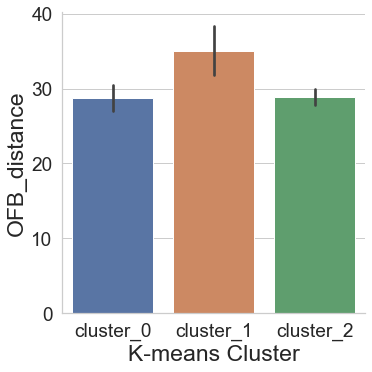

In [47]:
sns.set_theme(style="whitegrid")

plt.rc('xtick', labelsize=19) 
plt.rc('ytick', labelsize=19) 

order = ['cluster_0', 'cluster_1', 'cluster_2']

sns.catplot(x='kmeans_cluster', y='OFB_distance', kind='bar', ci=68, data=block_df_beh, 
            height=5, aspect=1, order=order, 
           )

plt.xlabel('K-means Cluster', fontsize=23)
plt.ylabel('OFB_distance', fontsize=23)


plt.show()